In [229]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import json_normalize
from flatten_json import flatten
import missingno as msno
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)

In [ ]:
player_data ="https://cdnapi.bamboo-video.com/api/football/stats?format=json&iid=573881b7181f46ae4c8b4567&filter={%22tournamentId%22:902,%22seasonName%22:%2222/23%22,%22round%22:0}&returnZeros=false&disableDefaultFilter=true&useCache=false&ts=28051780"
player_data_chapionshipround ="https://cdnapi.bamboo-video.com/api/football/stats?format=json&iid=573881b7181f46ae4c8b4567&filter={%22tournamentId%22:902,%22seasonName%22:%2222/23%22,%22round%22:1,%22stage%22:%22ChampionshipRound%22%20}&returnZeros=false&disableDefaultFilter=true&useCache=false&ts=28053136"
player_data_relegationround = "https://cdnapi.bamboo-video.com/api/football/stats?format=json&iid=573881b7181f46ae4c8b4567&filter={%22tournamentId%22:902,%22seasonName%22:%2222/23%22,%22round%22:1,%22stage%22:%22RelegationRound%22%20}&returnZeros=false&disableDefaultFilter=true&useCache=false&ts=28053136"
player_data_regularseason = "https://cdnapi.bamboo-video.com/api/football/stats?format=json&iid=573881b7181f46ae4c8b4567&filter={%22tournamentId%22:902,%22seasonName%22:%2222/23%22,%22round%22:1,%22stage%22:%22RegularSeason%22%20}&returnZeros=false&disableDefaultFilter=true&useCache=false&ts=28053136"

In [230]:
# Find the relevant links in the Premier League website
player_id ="https://cdnapi.bamboo-video.com/api/football/player?format=json&iid=573881b7181f46ae4c8b4567&returnZeros=true&useCache=false&ts=28051785"
club_id =  "https://cdnapi.bamboo-video.com/api/football/team?format=json&iid=573881b7181f46ae4c8b4567&filter={}&returnZeros=false&disableDefaultFilter=true&useCache=false&ts=28051793"
player_data_roundstage ="https://cdnapi.bamboo-video.com/api/football/stats?format=json&iid=573881b7181f46ae4c8b4567&filter={{%22tournamentId%22:902,%22seasonName%22:%2222/23%22,%22round%22:{R},%22stage%22:%22{S}%22%20}}&returnZeros=false&disableDefaultFilter=true&useCache=false&ts=28053136"
stage_ls =["RegularSeason","ChampionshipRound","RelegationRound","totalStage"]
# A function that convert the json files that were scraped from the website into dataframes 
def js_to_df(URL):
    page = requests.get(URL)
    js =page.json()
    js = js['data']
    ls_keys = list(js.keys())
    df = pd.DataFrame(data=[js[ls_keys[0]].values()])
    for i in range(1,len(ls_keys)):
        df= df.append([js[ls_keys[i]].values()])

    df.columns = js[ls_keys[0]].keys()
    return(df)

def js_to_df_rounds(URL,r,s):
    URL1 = URL.format(R=r,S=s)
    return js_to_df(URL1)


In [231]:
df_data_RegularSeason = pd.DataFrame()
df_data_ChampionshipRound = pd.DataFrame()
df_data_RelegationRound = pd.DataFrame()
for i in range(1,27):
    df_data_RegularSeason= pd.concat([df_data_RegularSeason,js_to_df_rounds(player_data_roundstage,r=i,s="RegularSeason")],ignore_index=True)

for i in range(1,8):
    df_data_ChampionshipRound= pd.concat([df_data_ChampionshipRound,js_to_df_rounds(player_data_roundstage,r=i,s='ChampionshipRound')],ignore_index=True)
    
for i in range(1,6):
    df_data_RelegationRound= pd.concat([df_data_RelegationRound,js_to_df_rounds(player_data_roundstage,r=i,s='RelegationRound')],ignore_index=True)

In [232]:
df_data_RegularSeason_team=df_data_RegularSeason[df_data_RegularSeason['playerId']==-1]
df_data_RegularSeason_player=df_data_RegularSeason[df_data_RegularSeason['playerId']!=-1]
df_data_ChampionshipRound_team=df_data_ChampionshipRound[df_data_ChampionshipRound['playerId']==-1]
df_data_ChampionshipRound_player=df_data_ChampionshipRound[df_data_ChampionshipRound['playerId']!=-1]
df_data_RelegationRound_team=df_data_RelegationRound[df_data_RelegationRound['playerId']==-1]
df_data_RelegationRound_player=df_data_RelegationRound[df_data_RelegationRound['playerId']!=-1]

In [233]:
df_team_season_data = pd.concat([df_data_RegularSeason_team,df_data_ChampionshipRound_team,df_data_RelegationRound_team],ignore_index=True)
df_player_season_data = pd.concat([df_data_RegularSeason_player,df_data_ChampionshipRound_player,df_data_RelegationRound_player],ignore_index=True)
df_player_id = js_to_df(player_id)
df_club_id = js_to_df(club_id)

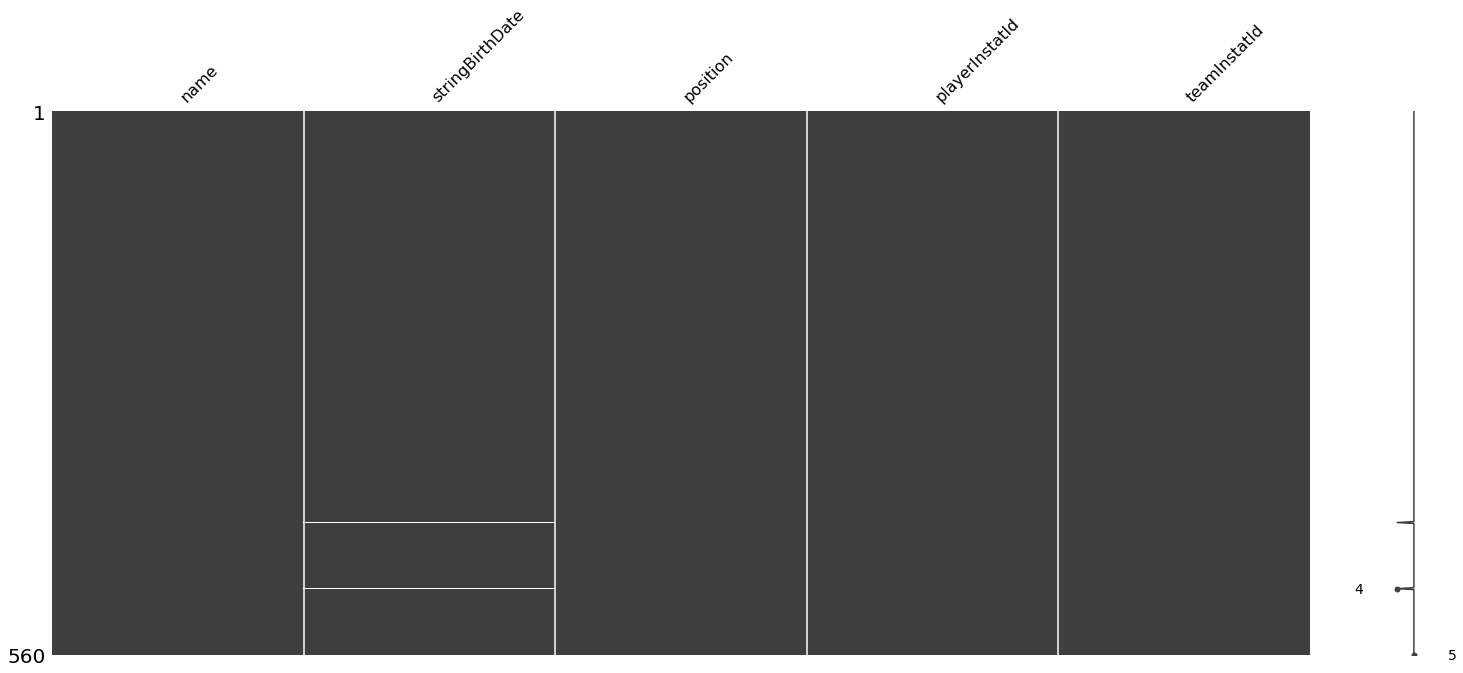

,name,stringBirthDate,position,playerInstatId,teamInstatId
423,Dolev Zilberberg,None,mid-fielder,1724099,2425
491,Leo Benbenisti,None,mid-fielder,1452318,130


In [234]:
# select relevat data and find na
df_player_filter = df_player_id.loc[:,['name','stringBirthDate','position','instatId','teamInstatId']].rename(columns={'instatId':'playerInstatId'}).reset_index(drop=True)
msno.matrix(df_player_filter)
plt.show()
df_player_filter[df_player_filter.isnull().any(axis=1)]

In [235]:
df_player_filter.loc[423,"stringBirthDate"]= "2002-01-01"
df_player_filter.loc[491,"stringBirthDate"]= "2004-01-01"
df_player_filter.stringBirthDate = pd.to_datetime(df_player_filter.stringBirthDate)
df_player_filter['player_age']= (pd.to_datetime("2023") - df_player_filter.stringBirthDate)/np.timedelta64(1, 'Y')

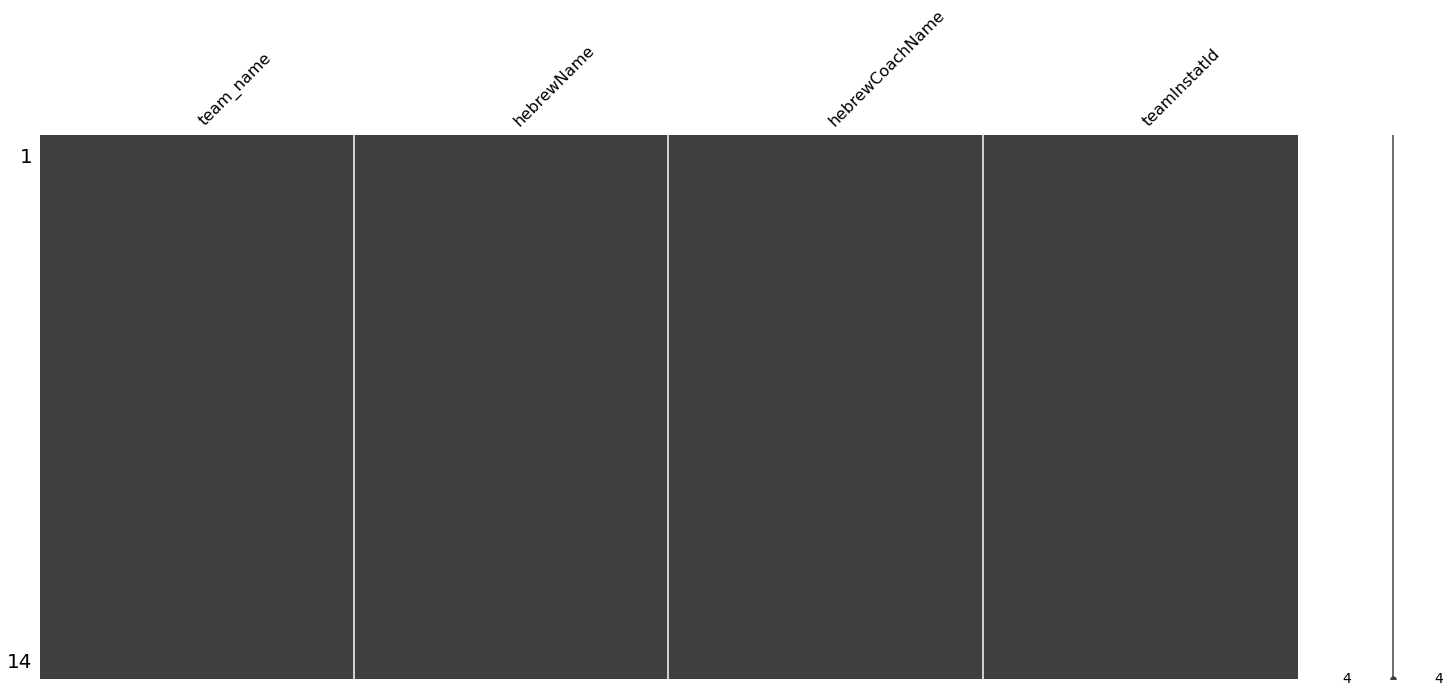

In [236]:
# select relevat data and find na
df_club_filter=df_club_id[df_club_id['leagueId']==902].loc[:,['name','hebrewName','hebrewCoachName','instatId']].rename(columns={'instatId':'teamInstatId','name':"team_name"}).reset_index(drop=True)
msno.matrix(df_club_filter)
plt.show()
df_club_filter.loc[11,"hebrewCoachName"]="זיו אריה"
df_club_filter.loc[13,"hebrewCoachName"]="שרון מימר"

In [237]:
# create a dataframe of palyer name,id,team name and team id
df_player_filter.teamInstatId = df_player_filter.teamInstatId.astype("int")
df_club_filter.teamInstatId = df_club_filter.teamInstatId.astype("int")
df_player_team=df_player_filter.merge(df_club_filter, on='teamInstatId')

In [238]:
# Create a stat data frame by player and team
df_player_season_data=df_player_season_data.merge(df_player_team,on="playerInstatId").iloc[:,5:]
df_team_season_data= df_team_season_data.merge(df_player_team.loc[:,["hebrewName","hebrewCoachName","team_name",'teamInstatId']].drop_duplicates(ignore_index=True),on="teamInstatId").iloc[:,7:]

In [241]:
# Results
display(df_team_season_data.head())
display(df_player_season_data.tail())

,teamId,teamInstatId,gameId,gameInstatId,round,seasonName,stage,tournamentId,penalties,Goal,Clearance,OwnGoal,YellowCard,RedCard,PenaltyKick,PenaltyShot_Goal,cleanNet,MissedPenalty,SubIn,SubOut,ShotInsidetheArea,GoalRegular,ShotOutsidetheArea,blockedShot,Assist,Cross,Corner,OffTarget,OnTarget,Blocked,AttemptOnTargetSavedbyGK,CopedAttemptOnTargetSavedbyGK,ThreatDeniedbyGK,ThreatToGK,DirectCrossintotheArea,DirectShot,missedShot,AttackingFK,Offside,Header,AttemptonGoal,CopedAttemptonGoal,CopedGoal,CopedMissedPenalty,appearances,totalDistance,averageDistance,topSpeed,averageSpeed,sprints,averageSprints,totalMinutesPlayed,keyPasses,passes,nonAttackingPasses,attackingPasses,accuratePasses,accurateKeyPasses,CopedOnTarget,CopedThreatDeniedbyGK,CopedPenaltyShot_Goal,CopedPenaltyShot,airChallenge,wonAirChallenge,groundChallenge,wonGroundChallenge,dribble,wonDribble,flankAttacks,foul,steals,wonSteals,ballRecoveryInOppHalf,ballRecoveryInOwnHalf,longBall,accurateLongBall,leftSideAttack,rightSideAttack,centerAttack,leftSideAttackWithShot,rightSideAttackWithShot,centerAttackWithShot,lostBall,ownHalfLostBall,opponentHalfBallRecovery,goalMistake,goodInterceptionGoalie,tackles,tacklesSuccess,ballPossession,CounterAttacks,PositionalAttacks,SetPieceAttacks,ballRecovery,opponentFoul,gamesPlayed,opponentTotalDistance,opponentSprints,opponentShotInsidetheArea,opponentShotOutsidetheArea,opponentHeader,opponentPenaltyShot_Goal,opponentCross,opponentGoal,chanceTotal,accurateAttackingPasses,accurateCrosses,hebrewName,hebrewCoachName,team_name
0,14316,1037,228969,2343391,1,22/23,RegularSeason,902,None,0,0,0,1,0,0,0,0,0,0,0,4,2,3,1,1,8,0,0,3,0,0,2,0,0,0,0,3,0,2,0,7,0,0,0,0,0,0,0,0,0,0,0,7,330,0,323,270,2,0,0,0,0,31,13,105,59,17,9,0,9,54,0,5,49,37,24,21,16,18,3,1,3,69,23,0,0,2,30,20,34.60,9,46,2,54,13,0,0,0,0,0,0,0,0,0,3,268,4,הפועל חיפה,רוני לוי,Hapoel Haifa
1,14316,1037,228979,2346419,2,22/23,RegularSeason,902,None,0,0,0,1,0,0,1,0,0,0,0,5,1,6,2,0,5,3,0,6,0,0,3,0,0,0,0,4,0,2,0,11,0,1,0,0,0,0,0,0,0,0,0,5,455,0,450,380,2,0,0,0,0,28,18,104,47,16,8,0,10,50,0,8,42,24,13,25,30,12,3,3,1,67,17,0,0,4,29,17,43.01,14,53,9,50,11,0,0,0,0,0,0,0,0,0,2,378,3,הפועל חיפה,רוני לוי,Hapoel Haifa
2,14316,1037,228985,2351463,3,22/23,RegularSeason,902,None,0,0,0,2,1,0,0,0,0,0,0,3,1,2,0,1,7,2,0,2,0,0,4,0,0,0,0,3,0,1,0,5,0,2,0,0,0,0,0,0,0,0,0,4,424,0,420,339,2,0,0,0,0,28,12,90,42,17,9,0,13,43,0,7,36,37,20,20,28,15,1,1,2,59,16,0,0,5,28,13,43.11,8,55,5,43,14,0,0,0,0,0,0,0,0,0,2,337,3,הפועל חיפה,רוני לוי,Hapoel Haifa
3,14316,1037,228988,2357003,4,22/23,RegularSeason,902,None,0,0,0,1,0,0,0,0,0,0,0,2,1,0,0,1,14,2,0,1,0,0,0,0,0,0,0,1,0,5,0,2,0,1,0,0,0,0,0,0,0,0,0,6,651,0,645,546,3,0,0,0,0,41,20,118,61,17,10,0,8,67,0,12,55,31,23,37,45,13,1,0,0,82,10,0,0,1,34,19,62.67,16,79,8,67,15,0,0,0,0,0,0,0,0,0,3,543,6,הפועל חיפה,רוני לוי,Hapoel Haifa
4,14316,1037,229001,2357008,5,22/23,RegularSeason,902,None,0,0,0,3,0,0,0,0,0,0,0,4,0,1,3,0,9,9,0,3,0,0,6,0,0,0,0,2,0,3,0,5,0,0,0,0,0,0,0,0,0,0,0,8,340,0,332,243,4,0,0,0,0,57,22,103,42,18,7,0,15,47,0,6,41,36,28,22,28,24,2,0,1,84,26,0,0,4,42,16,36.13,22,52,13,47,12,0,0,0,0,0,0,0,0,0,5,239,3,הפועל חיפה,רוני לוי,Hapoel Haifa


,playerId,playerInstatId,teamId,teamInstatId_x,gameId,gameInstatId,round,seasonName,stage,tournamentId,penalties,Goal,Clearance,OwnGoal,YellowCard,RedCard,PenaltyKick,PenaltyShot_Goal,cleanNet,MissedPenalty,SubIn,SubOut,ShotInsidetheArea,GoalRegular,ShotOutsidetheArea,blockedShot,Assist,Cross,Corner,OffTarget,OnTarget,Blocked,AttemptOnTargetSavedbyGK,CopedAttemptOnTargetSavedbyGK,ThreatDeniedbyGK,ThreatToGK,DirectCrossintotheArea,DirectShot,missedShot,AttackingFK,Offside,Header,AttemptonGoal,CopedAttemptonGoal,CopedGoal,CopedMissedPenalty,appearances,totalDistance,averageDistance,topSpeed,averageSpeed,sprints,averageSprints,totalMinutesPlayed,keyPasses,passes,nonAttackingPasses,attackingPasses,accuratePasses,accurateKeyPasses,CopedOnTarget,CopedThreatDeniedbyGK,CopedPenaltyShot_Goal,CopedPenaltyShot,airChallenge,wonAirChallenge,groundChallenge,wonGroundChallenge,dribble,wonDribble,flankAttacks,foul,steals,wonSteals,ballRecoveryInOppHalf,ballRecoveryInOwnHalf,longBall,accurateLongBall,leftSideAttack,rightSideAttack,centerAttack,leftSideAttackWithShot,rightSideAttackWithShot,centerAttackWithShot,lostBall,ownHalfLostBall,opponentHalfBallRecovery,goalMistake,goodInterceptionGoalie,tackles,tacklesSuccess,ballPossession,CounterAttacks,PositionalAttacks,SetPieceAttacks,ballRecovery,opponentFoul,gamesPlayed,opponentTotalDistance,opponentSprints,opponentShotInsidetheArea,opponentShotOutsidetheArea,opponentHeader,opponentPenaltyShot_Goal,opponentCross,opponentGoal,chanceTotal,accurateAttackingPasses,accurateCrosses,name,stringBirthDate,position,teamInstatId_y,player_age,team_name,hebrewName,hebrewCoachName
8494,573808,1453273,14316,1037,241490,2565931,2,22/23,RelegationRound,902,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Noam Ben Harush,2005-05-13,mid-fielder,1037,17.637597,Hapoel Haifa,הפועל חיפה,רוני לוי
8495,573808,1453273,14316,1037,241522,2574862,5,22/23,RelegationRound,902,None,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,7,0,4,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Noam Ben Harush,2005-05-13,mid-fielder,1037,17.637597,Hapoel Haifa,הפועל חיפה,רוני לוי
8496,562389,1156463,4530,130,241512,2571097,4,22/23,RelegationRound,902,None,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,21,0,2,0,2,2,0,0,0,0,0,2,0,6,1,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,2,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,Liad Ramot,2004-04-22,forward,130,18.694429,Hapoel Tel Aviv,"הפועל ת""א",חיים סילבס
8497,562389,1156463,4530,130,241520,2574863,5,22/23,RelegationRound,902,None,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,19,2,6,0,4,3,0,0,0,0,0,1,0,3,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,Liad Ramot,2004-04-22,forward,130,18.694429,Hapoel Tel Aviv,"הפועל ת""א",חיים סילבס
8498,571095,1448789,22998,13240,241511,2571100,4,22/23,RelegationRound,902,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Shahar Golan,2003-01-07,goalie,13240,19.983983,Hapoel Hadera,הפועל חדרה,ניסו אביטן


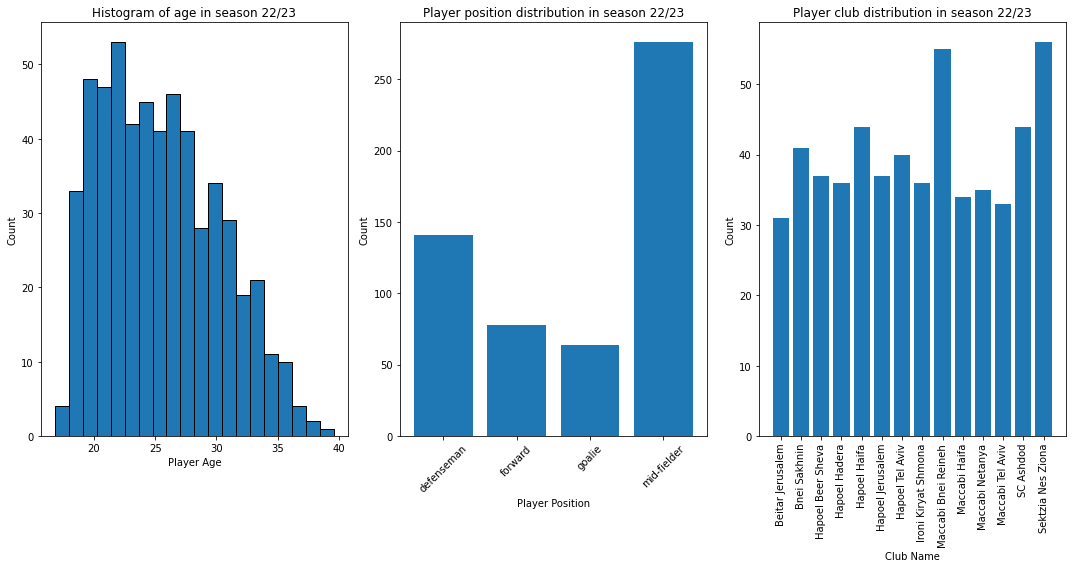

In [321]:
# Example, Expolratory Data analysis
fig,ax = plt.subplots(1,3,figsize=(15,8))
ax[0].hist(df_player_team['player_age'],edgecolor="black",bins=20)
ax[0].set_title("Histogram of age in season 22/23")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Player Age")

ax[1].bar(height=df_player_team.groupby("position").size(),x=list(df_player_team.groupby("position").size().index))
ax[1].set_title("Player position distribution in season 22/23")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Player Position")
ax[1].set_xticklabels(labels=list(df_player_filter.groupby("position").size().index),rotation=45)

ax[2].bar(height=df_player_team.groupby("team_name").size(),x=list(df_player_team.groupby("team_name").size().index))
ax[2].set_title("Player club distribution in season 22/23")
ax[2].set_ylabel("Count")
ax[2].set_xlabel("Club Name")
ax[2].set_xticklabels(labels=list(df_player_team.groupby("team_name").size().index),rotation=90)

plt.tight_layout()
plt.show()

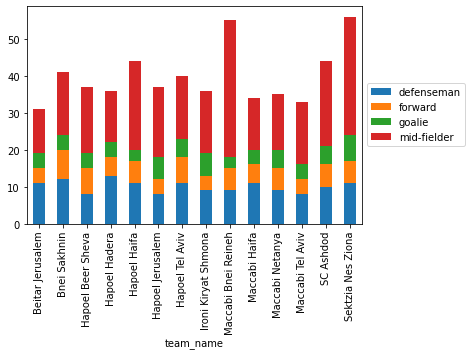

In [323]:
df_player_team.groupby(["team_name","position"]).size().unstack().plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

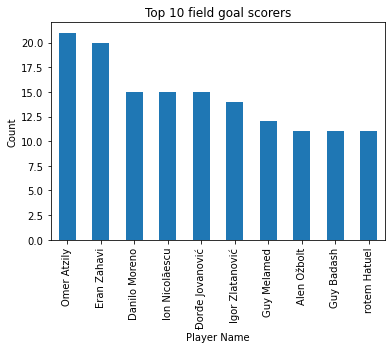

In [259]:
df_player_season_data.groupby("name").sum().GoalRegular.nlargest(10).plot.bar()
plt.ylabel("Count")
plt.xlabel("Player Name")
plt.title("Top 10 field goal scorers")
plt.show()